In [1]:
from nltk import bigrams, word_tokenize
from nltk.util import ngrams

import warnings
warnings.simplefilter("ignore")

sentence = "I am a boy."
tokens = word_tokenize(sentence)

bigram = bigrams(tokens)
trigram = ngrams(tokens, 3)

print("\nbigram:")
for t in bigram:
    print(t)

print("\ntrigram:")
for t in trigram:
    print(t)


bigram:
('I', 'am')
('am', 'a')
('a', 'boy')
('boy', '.')

trigram:
('I', 'am', 'a')
('am', 'a', 'boy')
('a', 'boy', '.')


In [2]:
bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="SS", right_pad_symbol="SE")
for t in bigram:
    print(t)

('SS', 'I')
('I', 'am')
('am', 'a')
('a', 'boy')
('boy', '.')
('.', 'SE')


In [3]:
from nltk import ConditionalFreqDist

sentence = "I am a boy."
tokens = word_tokenize(sentence)
bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="SS", right_pad_symbol="SE")
cfd = ConditionalFreqDist([(t[0], t[1]) for t in bigram])

In [4]:
cfd.conditions()

['SS', 'I', 'am', 'a', 'boy', '.']

In [5]:
cfd["SS"]

FreqDist({'I': 1})

In [6]:
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
from nltk.corpus import movie_reviews

sentences = []
for tokens in movie_reviews.sents():
    bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="SS", right_pad_symbol="SE")
    sentences += [t for t in bigram]

sentences[:20]

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Swalllow1219\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Swalllow1219\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('SS', 'plot'),
 ('plot', ':'),
 (':', 'two'),
 ('two', 'teen'),
 ('teen', 'couples'),
 ('couples', 'go'),
 ('go', 'to'),
 ('to', 'a'),
 ('a', 'church'),
 ('church', 'party'),
 ('party', ','),
 (',', 'drink'),
 ('drink', 'and'),
 ('and', 'then'),
 ('then', 'drive'),
 ('drive', '.'),
 ('.', 'SE'),
 ('SS', 'they'),
 ('they', 'get'),
 ('get', 'into')]

In [7]:
cfd = ConditionalFreqDist(sentences)

In [8]:
cfd["SS"].most_common(5)

[('the', 7965), ('it', 3038), ('i', 2350), ('but', 1754), ('he', 1642)]

In [9]:
cfd["i"].most_common(5)

[("'", 1357), ('was', 506), ('can', 351), ('have', 330), ('don', 276)]

In [10]:
cfd["."].most_common(5)

[('SE', 57626), ('.', 1893), ('"', 1854), (')', 535), ('s', 129)]

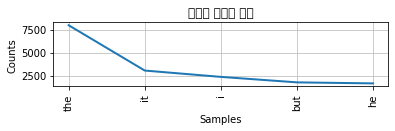

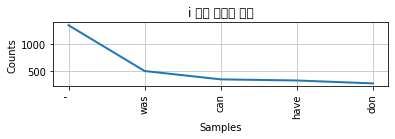

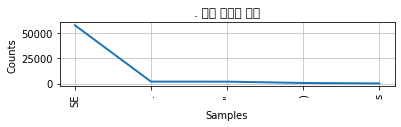

<AxesSubplot:title={'center':'. 다음 단어의 분포'}, xlabel='Samples', ylabel='Counts'>

In [11]:
import matplotlib.pyplot as plt
plt.subplot(311)
cfd["SS"].plot(5, title="문장의 첫단어 분포")
plt.subplot(312)
cfd["i"].plot(5, title="i 다음 단어의 분포")
plt.subplot(313)
cfd["."].plot(5, title=". 다음 단어의 분포")

In [12]:
from nltk.probability import ConditionalProbDist, MLEProbDist
cpd = ConditionalProbDist(cfd, MLEProbDist)

In [13]:
cpd["i"].prob("am")

0.018562267971650354

In [14]:
cpd["i"].prob("is")

0.0002249971875351558

In [15]:
cpd["we"].prob("are")

0.08504504504504505

In [16]:
cpd["we"].prob("is")

0.0

In [17]:
import numpy as np

def sentence_score(s):
    p = 0.0
    for i in range(len(s) - 1):
        c = s[i]
        w = s[i + 1]
        p += np.log(cpd[c].prob(w) + np.finfo(float).eps)
    return np.exp(p)

In [18]:
test_sentence = ["i", "like", "the", "movie", "."]
sentence_score(test_sentence)

2.740764134071561e-06

In [19]:
test_sentence = ["like", "i", "the", ".", "movie"]
sentence_score(test_sentence)

2.0530004609775863e-27

In [20]:
def generate_sentence(seed=None):
    if seed is not None:
        import random
        random.seed(seed)
    c = "SS"
    sentence = []
    while True:
        if c not in cpd:
            break
        w = cpd[c].generate()

        if w == "SE":
            break
        elif w in ["i", "ii", "iii"]:
            w2 = w.upper()
        elif w in ["mr", "luc", "i", "robin", "williams", "cindy", "crawford"]:
            w2 = w.title()
        else:
            w2 = w

        if c == "SS":
            sentence.append(w2.title())
        elif c in ["`", "\"", "'", "("]:
            sentence.append(w2)
        elif w in ["'", ".", ",", ")", ":", ";", "?"]:
            sentence.append(w2)
        else:
            sentence.append(" " + w2)

        c = w
    return "".join(sentence)

In [21]:
generate_sentence(6)

'Susan egan (or even remotely comprehendible.'

In [22]:
import codecs
with codecs.open("ratings_train.txt", encoding='utf-8') as f:
    data = [line.split('\t') for line in f.read().splitlines()]
    data = data[1:]   # header 제외

docs = [row[1] for row in data]
len(docs)

150000

In [23]:
import warnings
warnings.simplefilter("ignore")

from konlpy.tag import Okt

tagger = Okt()

def tokenize(doc):
    tokens = ['/'.join(t) for t in tagger.pos(doc)]
    return tokens

tokenize("그 영화는 아주 재미있었어요.")

['그/Noun', '영화/Noun', '는/Josa', '아주/Noun', '재미있었어요/Adjective', './Punctuation']

In [24]:
from tqdm import tqdm
sentences = []
for d in tqdm(docs):
    tokens = tokenize(d)
    bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="SS", right_pad_symbol="SE")
    sentences += [t for t in bigram]

100%|██████████| 150000/150000 [10:22<00:00, 241.04it/s]


In [25]:
sentences[:30]

[('SS', '아/Exclamation'),
 ('아/Exclamation', '더빙/Noun'),
 ('더빙/Noun', '../Punctuation'),
 ('../Punctuation', '진짜/Noun'),
 ('진짜/Noun', '짜증나네요/Adjective'),
 ('짜증나네요/Adjective', '목소리/Noun'),
 ('목소리/Noun', 'SE'),
 ('SS', '흠/Noun'),
 ('흠/Noun', '.../Punctuation'),
 ('.../Punctuation', '포스터/Noun'),
 ('포스터/Noun', '보고/Noun'),
 ('보고/Noun', '초딩/Noun'),
 ('초딩/Noun', '영화/Noun'),
 ('영화/Noun', '줄/Noun'),
 ('줄/Noun', '..../Punctuation'),
 ('..../Punctuation', '오버/Noun'),
 ('오버/Noun', '연기/Noun'),
 ('연기/Noun', '조차/Josa'),
 ('조차/Josa', '가볍지/Adjective'),
 ('가볍지/Adjective', '않구나/Verb'),
 ('않구나/Verb', 'SE'),
 ('SS', '너/Modifier'),
 ('너/Modifier', '무재/Noun'),
 ('무재/Noun', '밓었/Noun'),
 ('밓었/Noun', '다그/Noun'),
 ('다그/Noun', '래서/Noun'),
 ('래서/Noun', '보는것을/Verb'),
 ('보는것을/Verb', '추천/Noun'),
 ('추천/Noun', '한/Josa'),
 ('한/Josa', '다/Adverb')]

In [26]:
cfd = ConditionalFreqDist(sentences)
cpd = ConditionalProbDist(cfd, MLEProbDist)

def korean_most_common(c, n, pos=None):
    if pos is None:
        return cfd[tokenize(c)[0]].most_common(n)
    else:
        return cfd["/".join([c, pos])].most_common(n)

In [27]:
korean_most_common("나", 10)

[('는/Josa', 831),
 ('의/Josa', 339),
 ('만/Josa', 213),
 ('에게/Josa', 148),
 ('에겐/Josa', 84),
 ('랑/Josa', 81),
 ('한테/Josa', 50),
 ('참/Verb', 45),
 ('이/Determiner', 44),
 ('와도/Josa', 43)]

In [28]:
korean_most_common("의", 10)

[('영화/Noun', 19),
 ('연기/Noun', 14),
 ('구심/Noun', 12),
 ('모습/Noun', 9),
 ('감독/Noun', 8),
 ('매력/Noun', 7),
 ('감동/Noun', 7),
 ('흐름/Noun', 6),
 ('그/Noun', 6),
 ('이야기/Noun', 6)]

In [29]:
korean_most_common(".", 10, "Punctuation")

[('SE', 26503),
 ('영화/Noun', 667),
 ('이/Noun', 565),
 ('정말/Noun', 480),
 ('그리고/Conjunction', 455),
 ('./Punctuation', 445),
 ('하지만/Conjunction', 369),
 ('이/Determiner', 352),
 ('그/Noun', 325),
 ('스토리/Noun', 317)]

In [30]:
def korean_bigram_prob(c, w):
    context = tokenize(c)[0]
    word = tokenize(w)[0]
    return cpd[context].prob(word)

In [31]:
korean_bigram_prob("이", "영화")

0.4010748656417948

In [32]:
korean_bigram_prob("영화", "이")

0.00015767585785521414

In [33]:
def korean_generate_sentence(seed=None, debug=False):
    if seed is not None:
        import random
        random.seed(seed)
    c = "SS"
    sentence = []
    while True:
        if c not in cpd:
            break
            
        w = cpd[c].generate()

        if w == "SE":
            break

        w2 = w.split("/")[0]
        pos = w.split("/")[1]

        if c == "SS":
            sentence.append(w2.title())
        elif c in ["`", "\"", "'", "("]:
            sentence.append(w2)
        elif w2 in ["'", ".", ",", ")", ":", ";", "?"]:
            sentence.append(w2)
        elif pos in ["Josa", "Punctuation", "Suffix"]:
            sentence.append(w2)
        elif w in ["임/Noun", "것/Noun", "는걸/Noun", "릴때/Noun",
                   "되다/Verb", "이다/Verb", "하다/Verb", "이다/Adjective"]:
            sentence.append(w2)
        else:
            sentence.append(" " + w2)
        c = w

        if debug:
            print(w)

    return "".join(sentence)

In [34]:
korean_generate_sentence(0)

'미키짱과 말도 전혀 빗나가지 않던 전개로 꽥꽥대는거 보니까 요^^'

In [35]:
korean_generate_sentence(1)

'내용 일테인데 이 영화 최고의 암살 할려고 한 데 선배랑 김선아 연기도 크다. 배슬기 여배우도 있는 척 하는거지?'

In [36]:
korean_generate_sentence(2)

'도리까지 본 영화 너무... 뭔가.. 최고네요. 하지만.. 눈물 낫다는건 또 영화에 들지 않는다. 근데 뭐야 어떻게 그렇게 착했던 윤재랑은 에바 그린 드레스 소리 듣는거임""" 에리 욧의 미모로 합성 한 가수 노래와 흥행 놓친 영화다. 사투리 연기 하나 없는 ‘ 스피드 감 넘치는 스릴 넘치는 연기를 이해 되지 못 하시는 분보다 훨 재밌구만 평점을 망처 놓은 듯하다. 영화 보는이로 하여금 불편함을 느꼇을듯'

In [37]:
korean_generate_sentence(3)

'내 인생을 반헬싱이 너무 무섭고 재밌고, 칼 세이건으로 연탄가스 맡아서 죽을 같이 작업 하는구나 ㅋㅋㅋㅋㅋ 진짜'

In [38]:
korean_generate_sentence(5)

'좋았어요... ㅎㄷㄷㄷ 시나리오나 그래픽이 대단한 심리전이 미라 파스틱 함.. 너무 무섭고 나쁜세 끼는 듯 진짜 꼭 필요가 있는지도 모르겠지만 나름 그의 복수 후!!!!!!!!!!!'